In [1]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist

import tqdm

import warnings
warnings.filterwarnings('ignore')

# import sys
# sys.path.insert(0,"..")

# from modules.HetMOGP import HetMOGP

In [242]:
class ExactGP(gpytorch.models.ExactGP):
            
    def __init__(self, train_x, train_y, likelihood, kernel):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel
                
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
input_dim = 2
train_x = None
train_y = None

# initialise the model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
kernel1 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=input_dim))
model1 = ExactGP(train_x=train_x, train_y=train_y, likelihood=likelihood, kernel=kernel1)

hypers = [
    {
        'likelihood.noise_covar.noise': torch.tensor(1),
        'covar_module.outputscale': torch.tensor(1.),
        'covar_module.base_kernel.lengthscale': torch.tensor([.7, .9]),
    }
]

# non-surface
N = 1000
torch.manual_seed(55)
# X = torch.vstack([torch.linspace(0, 1, N), torch.randn(N)]).permute(1,0)
X = torch.randn((N,input_dim))
Y = torch.empty(N)

In [243]:
torch.manual_seed(55)
model1.initialize(**hypers[0])
model1.eval()
with gpytorch.settings.prior_mode(True):
    Y = model1(X).sample()

torch.manual_seed(55)
f_11 = Y
f_12 = .5
y_1 = torch.normal(f_11, f_12)

<AxesSubplot:>

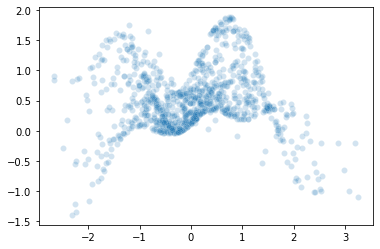

In [244]:
sns.scatterplot(X[:,0], f_11, alpha=.2)

<AxesSubplot:>

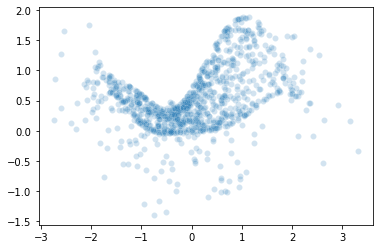

In [245]:
sns.scatterplot(X[:,1], f_11, alpha=.2)

<AxesSubplot:>

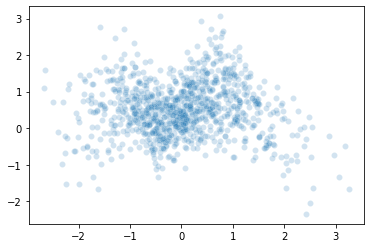

In [246]:
sns.scatterplot(X[:,0], y_1, alpha=.2)

<AxesSubplot:>

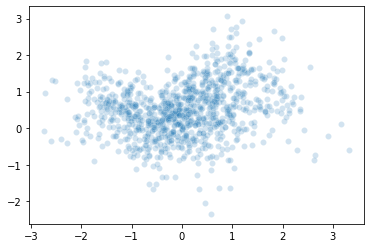

In [247]:
sns.scatterplot(X[:,1], y_1, alpha=.2)

In [248]:
train_x = X
train_y = y_1
test_x = X

# if torch.cuda.is_available():
#     train_x, train_y, test_x = train_x.cuda(), train_y.cuda(), test_x.cuda()

In [258]:
class PVGPRegressionModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_inducing=100, name_prefix="mixture_gp"):
        self.name_prefix = name_prefix

        # Define all the variational stuff
        inducing_points = torch.randn((num_inducing,2))
        # inducing_points = torch.linspace(0, 1, num_inducing).expand(1, 2, num_inducing).permute(0,2,1)[0,...]
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points,
            gpytorch.variational.MeanFieldVariationalDistribution(num_inducing_points=num_inducing),
        )

        # Standard initializtation
        super().__init__(variational_strategy)

        # Mean, covar, likelihood
        self.mean_module = gpytorch.means.ConstantMean()
        lengthscale_prior = gpytorch.priors.GammaPrior(2.0, 4.0)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.AdditiveKernel(
            gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior, active_dims=[0]),
            gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior, active_dims=[1])))

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    @pyro.poutine.scale(scale=1.0/(1000.0))
    def guide(self, x, y):
        # Get q(f) - variational (guide) distribution of latent function
        function_dist = self.pyro_guide(x)

        # Use a plate here to mark conditional independencies
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            pyro.sample(self.name_prefix + ".f(x)", function_dist)

    @pyro.poutine.scale(scale=1.0/(1000.0))
    def model(self, x, y):
        pyro.module(self.name_prefix + ".gp", self)

        # Get p(f) - prior distribution of latent function
        function_dist = self.pyro_model(x)

        # Use a plate here to mark conditional independencies
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            function_samples = pyro.sample(self.name_prefix + ".f(x)", function_dist)

            # Use the link function to convert GP samples into scale samples
            f = function_samples

            # Sample from observed distribution
            return pyro.sample(
                self.name_prefix + ".y",
                pyro.distributions.Normal(f, torch.tensor([.5])),  # rate = 1 / scale
                obs=y
            )

In [259]:
model = PVGPRegressionModel()

In [260]:
pyro.clear_param_store()

# num_iter = 2000
num_iter = 1200
num_particles = 10

# If getting Matrix not PSD error try:
# - decreasing gamma = 1e-3 / decreasing final_lr = 1e-3 (for fast training, try final_lr = 1e-2)

initial_lr = 1e-1
final_lr = 1e-3
gamma = final_lr / initial_lr  # final learning rate will be gamma * initial_l|r
lrd = gamma ** (1 / num_iter) # learning rate decay

optimizer = pyro.optim.ClippedAdam({
    'lr': initial_lr, 
    'lrd': lrd,
    'betas': (0.95, 0.999)})

elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
# elbo = pyro.infer.Trace_ELBO(vectorize_particles=True, retain_graph=True)
svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

model.train()
iterator = tqdm.notebook.tqdm(range(num_iter), desc="Epoch")
loss_array = np.zeros(num_iter)
for i in iterator:
    model.zero_grad()
    # model(train_x, task_indices="YOLO")
    # model(train_x, task_indices=task_indices)
    loss = svi.step(x=train_x, y=train_y)
    loss_array[i] = loss
    iterator.set_postfix(loss=loss)

Epoch:   0%|          | 0/1200 [00:00<?, ?it/s]

<AxesSubplot:>

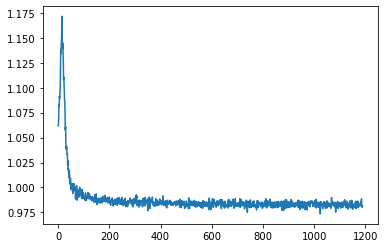

In [261]:
loss_start = 10
sns.lineplot(np.arange(0, len(loss_array) - loss_start), loss_array[loss_start:])

In [262]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

In [268]:
model.eval()

with torch.no_grad():
    output = model(test_x)

# Similarly get the 5th and 95th percentiles
samples = output(torch.Size([1000]))
mu_sim = model(test_x)()

lower, mean, upper = percentiles_from_samples(samples.cpu())
train_x, train_y, test_x = train_x.cpu(), train_y.cpu(), test_x.cpu()

# Draw some simulated y values
y_sim = dist.Normal(mu_sim.detach(),torch.tensor([.5]))()

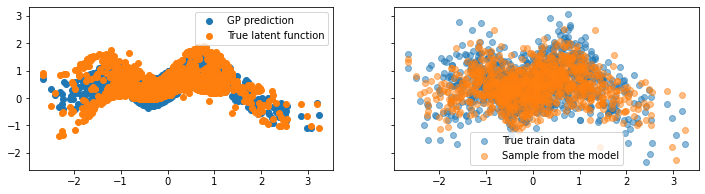

In [273]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3), sharey=True)
func.scatter(test_x[:,0], mean.detach().cpu().numpy(), label='GP prediction')
# func.fill_between(
#     test_x[:,0], lower[:,0].squeeze().detach().cpu().numpy(),
#     upper[:,0].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
# )

func.scatter(test_x[:,0], f_11, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x[:,0], train_y, alpha = 0.5, label='True train data')
samp.scatter(train_x[:,0], y_sim.cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

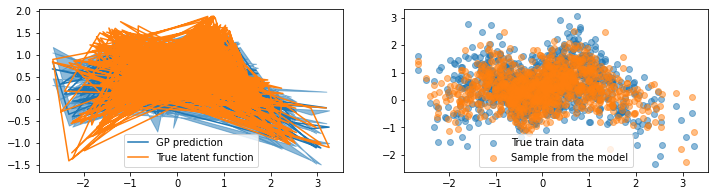

In [270]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x[:,0], mean.detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x[:,0], lower.squeeze().detach().cpu().numpy(),
    upper.squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x[:,0], f_11, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x[:,0], train_y, alpha = 0.5, label='True train data')
samp.scatter(train_x[:,0], y_sim.cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

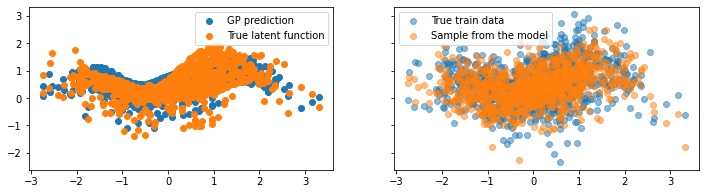

In [272]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3), sharey=True)
func.scatter(test_x[:,1], mean.detach().cpu().numpy(), label='GP prediction')
# func.fill_between(
#     test_x[:,1], lower.squeeze().detach().cpu().numpy(),
#     upper.squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
# )

func.scatter(test_x[:,1], f_11, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x[:,1], train_y, alpha = 0.5, label='True train data')
samp.scatter(train_x[:,1], y_sim.cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()